In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding


import math
from typing import Optional, Tuple, Union


from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled

from os import path
from scipy.optimize import minimize
import d3rlpy
from d3rlpy.dataset import MDPDataset

from d3rlpy.metrics import EnvironmentEvaluator
from sklearn.model_selection import train_test_split




class toy_env(gym.Env):
    """
    1-D toy MDP:
      S in [0,5], A in {0,1}.
      Reward: r(s,a) = (26 - s^2 - I[a=1]) / 26  \in [0,1].
      Transition (with clipping to [0,5]):
        if a=0: s' ~ Uniform( max(s-0.2, 0), min(s+1.0, 5) )
        if a=1: s' ~ Uniform( max(0.2*s - 0.02, 0), min(s+0.5, 5) )


    """

    def __init__(self, max_episode_steps: int = 100):
        super().__init__()
        self.observation_space = spaces.Box(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([5.0], dtype=np.float32),
            dtype=np.float32,
        )
        self.action_space = spaces.Discrete(2)

        self.max_episode_steps = int(max_episode_steps)
        self._elapsed_steps = 0
        self.state: float | None = None

        # rng
        self.np_random, _ = seeding.np_random(None)

    # ---------- helpers ----------
    @staticmethod
    def _reward(s: float, a: int) -> float:
        return (26.0 - s**2 - (1.0 if a == 1 else 0.0)) / 26.0

    def _sample_next_state(self, s: float, a: int) -> float:
        if a == 0:
            lo, hi = s - 0.2, s + 1.0
        else:  # a == 1
            lo, hi = 0.2 * s - 0.02, s + 0.5
        lo = max(lo, 0.0)
        hi = min(hi, 5.0)
        return float(self.np_random.uniform(lo, hi) if hi > lo else lo)

    # ---------- Gymnasium API ----------
    def reset(self, *, seed: int | None = None, options: dict | None = None):
        if seed is not None:
            self.np_random, _ = seeding.np_random(seed)
   
        self.state = float(self.np_random.uniform(2.0, 3.0))
        self._elapsed_steps = 0
        obs = np.array([self.state], dtype=np.float32)
        return obs, {}

    def step(self, action: int):
        assert self.state is not None, "Call reset() before step()."
        a = int(action)
        if not self.action_space.contains(a):
            raise gym.error.InvalidAction(f"Invalid action {action!r}")

        s = self.state
        r = self._reward(s, a)
        s_next = self._sample_next_state(s, a)

        self.state = s_next
        self._elapsed_steps += 1

        obs = np.array([s_next], dtype=np.float32)
        terminated = False  # no absorbing terminal
        truncated = self._elapsed_steps >= self.max_episode_steps
        info = {}
        return obs, float(r), terminated, truncated, info


In [2]:
def custom_random_policy(state):
    return np.random.randint(0, 2)

In [3]:
def data_generation(EnvClass, policy, num_episodes = 100, seed_da = 10):
    
    env = EnvClass()
    states = []
    actions = []
    rewards = []
    terminals = []

    for tt in range(num_episodes):
        obs = env.reset(seed = seed_da+100*tt)[0]  # Reset the environment
        done = False

        while not done:
            action = policy(obs)  # Use a random policy
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the transition
            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            terminals.append(done)

            obs = next_obs  # Update current state

    # Convert to numpy arrays
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    terminals = np.array(terminals, dtype=np.bool_)

    dataset = MDPDataset(states, actions, rewards, terminals)
    
    return dataset



def evaluate_policy(policy, EnvClass, gamma=0.95, num_episodes = 100, seed = 20):

    env = EnvClass()
    rewards = []

    for tt in range(num_episodes):
        obs, _ = env.reset(seed = seed + tt*100)
        done = False
        episode_reward = 0
        discount = 1.0

        while not done:
            # Select action from the policy
            action = policy.sample_action(obs.reshape(1,-1)).item()

            # Step in the environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Accumulate discounted reward
            episode_reward += discount * reward
            discount *= gamma

            # Update observation
            obs = next_obs

        rewards.append(episode_reward)

    return np.mean(rewards) # Mean and standard deviation of rewards


In [4]:
def train_sac(MDP_data, env, gamma = 0.95):
    
    sac_beh = d3rlpy.algos.DiscreteSACConfig(gamma=gamma,initial_temperature=0.06,temp_learning_rate=0).create(device="cuda:0")
    sac_beh.build_with_dataset(MDP_data)
    env_evaluator = EnvironmentEvaluator(env)
    sac_beh.fit(MDP_data,
        n_steps=20000,
        n_steps_per_epoch=2000,
        show_progress=False,
        evaluators={
            'environment': env_evaluator,
        },
    )

    return sac_beh

In [ ]:
MDP_data = data_generation(EnvClass = toy_env, policy = custom_random_policy, num_episodes = 200)


In [ ]:
d3rlpy.seed(123)
sac_beh = train_sac(MDP_data, env = toy_env(), gamma = 0.95)

In [7]:
sac_beh.save("sac_model_toy.d3")

In [ ]:
import d3rlpy
import gym                 # old gym library
from gym import spaces
from gym.utils import seeding


class toy_env_gym(gym.Env):
    """
    1-D toy MDP (old gym edition that works for scope-rl):
      S in [0,5], A in {0,1}.
      Reward: r(s,a) = (30 - s^2 - 5 * I[a=1]) / 30 ∈ [0,1].
      Transition (clipped to [0,5]):
        if a=0: s' ~ Uniform(max(s-0.2, 0), min(s+1.0, 5))
        if a=1: s' ~ Uniform(max(0.2*s-0.02, 0), min(s+0.5, 5))


    """

    metadata = {}  

    def __init__(self, max_episode_steps: int = 100):
        super().__init__()
        self.observation_space = spaces.Box(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([5.0], dtype=np.float32),
            dtype=np.float32,
        )
        self.action_space = spaces.Discrete(2)

        self.max_episode_steps = int(max_episode_steps)
        self._elapsed_steps = 0
        self.state = None

  
        self.np_random, _ = seeding.np_random(None)

    # ---------- helpers ----------
    @staticmethod
    def _reward(s: float, a: int) -> float:
        return (30.0 - s**2 - 5.0 * (1.0 if a == 1 else 0.0)) / 30.0

    def _sample_next_state(self, s: float, a: int) -> float:
        if a == 0:
            lo, hi = s - 0.2, s + 1.0
        else:  # a == 1
            lo, hi = 0.2 * s - 0.02, s + 0.5
        lo = max(lo, 0.0)
        hi = min(hi, 5.0)
        return float(self.np_random.uniform(lo, hi) if hi > lo else lo)

 
    def reset(self, *, seed: int | None = None, options: dict | None = None):
        if seed is not None:
            self.np_random, _ = seeding.np_random(seed)
        
        self.state = float(self.np_random.uniform(2.0, 3.0))
        self._elapsed_steps = 0
        obs = np.array([self.state], dtype=np.float32)
        info = {}
        return obs, info

    def step(self, action: int):
        if not self.action_space.contains(action):
            raise gym.error.InvalidAction(f"Invalid action {action!r}")

        s = float(self.state)
        a = int(action)

        r = self._reward(s, a)
        s_next = self._sample_next_state(s, a)

        self.state = s_next
        self._elapsed_steps += 1

        obs = np.array([s_next], dtype=np.float32)
        terminated = False                    
        truncated = self._elapsed_steps >= self.max_episode_steps
        info = {}
        return obs, float(r), terminated, truncated, info



In [11]:
# import necessary module from SCOPE-RL
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS        
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS 
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import DoublyRobust as DR


In [12]:
toy_env_1 = toy_env_gym()

In [ ]:

behavior_policy = EpsilonGreedyHead(
    sac_beh,
    n_actions=2,
    epsilon=1.0,
    name="sac_beh",
    random_state=12345,
)


In [ ]:

sac_policy = EpsilonGreedyHead(
    sac_beh,
    n_actions=2,
    epsilon=0.0,
    name="sac_beh",
    random_state=12345,
)


'\n# create input for off-policy evaluation (OPE)\nprep = CreateOPEInput(\n    env=toy_env_1,\n    gamma=0.95,\n)\ninput_dict = prep.obtain_whole_inputs(\n    logged_dataset=logged_dataset,\n    evaluation_policies=[sac_policy],\n    require_value_prediction=True,\n    require_weight_prediction=False,\n    q_function_method = "fqe",\n    w_function_method = "mwl",\n    n_steps=10000,\n    n_trajectories_on_policy_evaluation=100,\n    random_state=123,\n)\n'

In [ ]:
d3rlpy.seed(2)
np.random.seed(2)
kkk = 10
ope_result = np.zeros((kkk, 3))

for i in range(kkk):
    # initialize dataset class
    dataset = SyntheticDataset(
        env=toy_env_1,
        max_episode_steps=100,
    )
    
    # data collection
    logged_dataset = dataset.obtain_episodes(
        behavior_policies=behavior_policy,
        n_trajectories=200,
        random_state=i,
    )
    
    prep = CreateOPEInput(
        env=toy_env_1,
        gamma=0.95,
    )
    input_dict = prep.obtain_whole_inputs(
        logged_dataset=logged_dataset,
        evaluation_policies=[sac_policy],
        require_value_prediction=True,
        n_steps=20000,
        n_trajectories_on_policy_evaluation=100,
        random_state=i*20,
    )
    
    ope = OPE(
        logged_dataset=logged_dataset,
        ope_estimators=[DM(), DR(),PDIS()],
    )
    policy_value_dict = ope.estimate_policy_value(
        input_dict=input_dict,
    )

    ope_result[i,0] = policy_value_dict["sac_beh"]["dm"]
    ope_result[i,1] = policy_value_dict["sac_beh"]["dr"]
    ope_result[i,2] = policy_value_dict["sac_beh"]["pdis"]




In [ ]:
np.savetxt("toy_ope_result.csv", ope_result, delimiter=",")

In [ ]:
import pandas as pd

wass_result = pd.read_csv("wass_result.csv", index_col=0)
wass_result = wass_result.to_numpy()

In [ ]:
wass_result

In [ ]:

tv_result = pd.read_csv("tv_result.csv", index_col=0)

tv_result = tv_result.to_numpy()

In [ ]:
tv_result

In [ ]:
est_value_abs = pd.read_csv("est_value_abs.csv", index_col=0)
est_value_abs = est_value_abs["x"].to_numpy()

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_ope_summary(wass_result, tv_result, ope_result, true_vals,show=True):
    x   = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0], dtype=float)
    z   = 1.96
    eps = 0.04

    def mean_ci(arr_2d):
        m = np.mean(arr_2d, axis=0)
        s = np.std(arr_2d, axis=0, ddof=1)
        n = arr_2d.shape[0]
        half = z * s / np.sqrt(n)
        return m, m - half, m + half

    def mean_ci_singlecol(col_1d, repeat_len=6):
        m = float(np.mean(col_1d)); s = float(np.std(col_1d, ddof=1)); n = len(col_1d)
        half = z * s / np.sqrt(n)
        return np.full(repeat_len, m), np.full(repeat_len, m-half), np.full(repeat_len, m+half)

    wass_mean, wass_lo, wass_hi = mean_ci(wass_result)
    tv_mean,   tv_lo,   tv_hi   = mean_ci(tv_result)
    dm_mean,   dm_lo,   dm_hi   = mean_ci_singlecol(ope_result[:, 0])
    dr_mean,   dr_lo,   dr_hi   = mean_ci_singlecol(ope_result[:, 1])
    #pdis_mean, pdis_lo, pdis_hi = mean_ci_singlecol(ope_result[:, 2])

    fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

    ax.fill_between(x, wass_lo, wass_hi, alpha=0.2, color="skyblue")
    ax.plot(x, wass_mean, marker="o", color="steelblue", label="Wass Method")

    ax.fill_between(x, tv_lo, tv_hi, alpha=0.2, color="orange")
    ax.plot(x, tv_mean, marker="o", color="darkorange", label="TV Method")

    ax.fill_between(x, dm_lo, dm_hi, alpha=0.2, color="lightgreen")
    ax.plot(x, dm_mean, marker="o", color="green", label="DM")

    ax.fill_between(x, dr_lo, dr_hi, alpha=0.2, color="plum")
    ax.plot(x, dr_mean, marker="o", color="purple", label="DR")

    #ax.fill_between(x, pdis_lo, pdis_hi, alpha=0.2, color="thistle")
    #ax.plot(x, pdis_mean, marker="o", color="indigo", label="PDIS")

    for xi, yi in zip(x, true_vals):
        ax.plot([xi - 0.04, xi + 0.04], [yi, yi], color="red", linewidth=3)
    ax.plot([], [], color="red", linewidth=3, label="True Value")

    ax.set_xlabel("Wass Dist")
    ax.set_ylabel("Value")
    #ax.set_title("Worst-case OPE with different Wass Perturbation")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

    if show:
        plt.show()
    return fig, ax

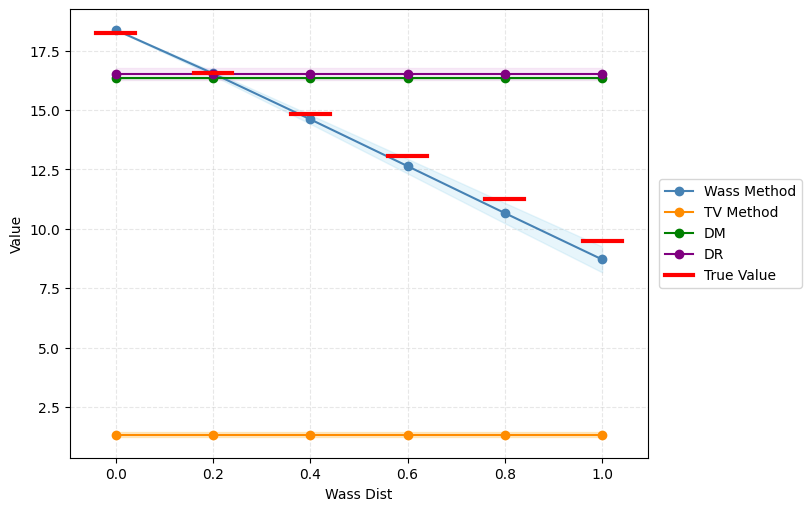

In [10]:
fig, ax = plot_ope_summary(wass_result= wass_result,
                     tv_result = tv_result,
                     ope_result = ope_result,   # shape (n_sims, 3) -> [DM, DR, PDIS]
                     true_vals = est_value_abs)

In [ ]:
fig.savefig("ope_plot.png", dpi=300, bbox_inches="tight")